In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
epochs = 500
batch_size = 256

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root="./data",
                                            train=True, download=True,
                                            transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               shuffle=True, pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified
dog


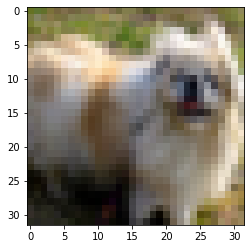

In [5]:
datas = torchvision.datasets.CIFAR10(root="./data",
                                            train=True, download=True,
                                            transform=None)
label_list = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

img_num = 40
print(label_list[datas[img_num][1]])
plt.imshow(datas[img_num][0])

In [6]:
class Discriminator(nn.Module):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256*2*2, 1)
        
    def forward(self, x):
        x = F.avg_pool2d(F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True), 2)
        x = F.avg_pool2d(F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True), 2)
        x = F.avg_pool2d(F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True), 2)
        x = F.avg_pool2d(F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True), 2)
        x = self.fc(x.view(self.batch_size, -1))
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convt1 = nn.ConvTranspose2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.convt2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.convt3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.convt4 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.convt1(x)), inplace=True)
        x = F.relu(self.bn2(self.convt2(x)), inplace=True)
        x = F.relu(self.bn3(self.convt3(x)), inplace=True)
        x = torch.tanh(self.convt4(x))
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_g = Generator().to(device)
print(model_g)
model_d = Discriminator(batch_size).to(device)
print(model_d)

Generator(
  (convt1): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2), bias=False)
)
Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_si

In [8]:
crit = nn.BCEWithLogitsLoss()

opt_g = optim.Adam(model_g.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(model_d.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
const_z = torch.randn(64, 128, 1, 1).to(device)
loss_list = []
for e in range(1, epochs+1):
    model_g.train()
    model_d.train()
    running_loss_g = 0.0
    running_loss_d = 0.0
    for i, (real_img, _) in enumerate(dataloader):
        if len(real_img) != batch_size:
            continue

        ones = torch.ones(batch_size, dtype=torch.float).view(batch_size, 1).to(device)
        zeros = torch.zeros(batch_size, dtype=torch.float).view(batch_size, 1).to(device)
            
        # Generatorの学習
        z = torch.randn(batch_size, 128, 1, 1).to(device)
        fake_img = model_g(z)
        fake_output = model_d(fake_img)
        loss_g = crit(fake_output, ones)

        model_g.zero_grad()
        loss_g.backward()
        opt_g.step()
        
        # Discriminatorの学習
        real_img = real_img.to(device)
        real_output = model_d(real_img)
        real_loss_d = crit(real_output, ones)

        fake_output = model_d(fake_img.detach())
        fake_loss_d = crit(fake_output, zeros)            
        loss_d = real_loss_d + fake_loss_d

        model_d.zero_grad()
        loss_d.backward()
        opt_d.step()

        running_loss_g += loss_g.item()
        running_loss_d += loss_d.item()

        if i%20 == 0:
            print('[Epoch:{}/{}][{}/{}] Loss_g:{:.5f} Loss_d:{:.5f}'.format(e, epochs, i, int(len(dataloader)), loss_g.item(), loss_d.item()))
    
    loss_list.append([running_loss_g/int(len(dataloader)), running_loss_d/int(len(dataloader))])
    if e%5 == 0:
        model_g.eval()
        print('save img of epoch {}'.format(e))
        if not os.path.exists("save_images"):
            os.mkdir("save_images")
        output_img = model_g(const_z)
        save_image(output_img, "save_images/{}.jpg".format(e))

[Epoch:1/500][0/196] Loss_g:0.68844 Loss_d:1.36395
[Epoch:1/500][20/196] Loss_g:2.49476 Loss_d:0.27726
[Epoch:1/500][40/196] Loss_g:4.03274 Loss_d:0.78852
